# **Optimization of Cubicle Office Space Due to Covid-19 Restrictions** 
*Caroline Murphy and Peter Stefos*

Due to Covid-19 restrictions certain buildings and rooms on RIT's campus must have a limited capcity to maintain social distancing standards set by New York State and to not overwhelm the current air handling system. One of these spaces is the Engineering PhD floor of building 84. This floor has offices, conference spaces, labs, and student cubicles. The space was approved to have a maximum number of 22 total occupants on the floor at one time. Since there must be room for other people (office users, lab users, and visitors) only 15 spaces are available for PhD students during the week between 8am-5pm. After 5pm on weekdays and all day on weekends all 22 spaces are available for PhD student use.

Each PhD student is assigned a cubicle and cubicle partner. They may not sit in another cube as this would not allow for proper contact tracing. There are 36 total PhD students and 18 cubicles.

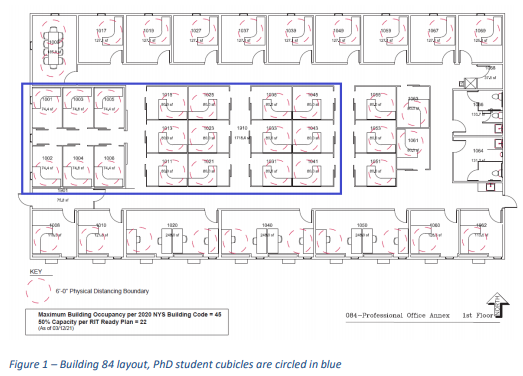

Each PhD student was given the opportunity to submit their preferred hours to work in their cubicle. they were allowed to pick up to 20 hours during the week between 8am-5pm and another 20 hours after 5pm on weekdays and on weekends.

The goal of this code it to find the optimal schdule for the PhD students given their requested work times and maximum occupancy levels. 

---

## Instructions on How to Use This Document

This code was written using the Google CoLab application. This allows users to run code using their web browser without installing a coding software such as Anaconda or PyCharm.



In order to run the code simply follow along scrolling down through the code and press the play buttons as they appear. Do not press the next play button until the last button appears as a number.


---



## Install Libraries

This code makes use of the Pyomo libraries and the glpk solver. Both are loaded here. This will only need to be re-installed once per session.

---



In [1]:
!pip install -q pyomo
!apt-get install -y -qq glpk-utils

     |████████████████████████████████| 9.5MB 18.2MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
     |████████████████████████████████| 256kB 52.2MB/s 
     |████████████████████████████████| 163kB 45.9MB/s 
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-1_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-1) ...
Selecting previously unselected package glpk

<h1>Problem Formulation </h1>

In [2]:
#code to set up the model
from pyomo.environ import * 
from pyomo.opt import SolverStatus, TerminationCondition
import sys
import csv
import os
import matplotlib.pyplot as plt
import pandas as pd

# ABSTRACT MODEL
model = AbstractModel()

## Sets
CUBICLE = i = The set of cubes avalible to PhD students 

STUDENT = j = The set of PhD student names that need to be placed 

HOURS = k = The set of hours avalible for students to be in the cubicle 

DAY = h = The set of the days of week 


---




In [3]:
#code to create sets in the model
model.CUBICLE = Set()
model.STUDENT = Set()
model.HOURS = Set()
model.DAY = Set()

##Parameters

$max\;people \;building_{kh} = total\;number\;of\;students\;that\;can\;be\;in\;building\;at\;time\;k\; on \; day\; h, \;\forall\; k \in HOURS, \forall\; h\;\in DAY$

$max\;people \;cubicle = total\;number\;of\;people\;that\;can\;be\;in\;cubicle\;at\;one\;time$

$preference\;hours_{jkh} = \;assign\; value\; of\; 1 \; to \;student\; j\; at\;hour\; k\; on \;day\; h\; if \;hour \; is\; preferred\;or\; else\; assign\; 0, \forall \; j \in STUDENT,\; \forall \; k \in HOURS, \; \forall \; h \in DAY$

$workstation\;assign_{ji} = \;assigns\; student \;j\; to\; their \; designated\;cube\; i,\;  \forall \; j \in STUDENT,\; \forall \; i \in CUBICLE$

$max\;hours\;allowed = \;maximum\; number\; of\; hours \; student\;can\;be\; assigned\; to\; a\; cubicle\;$

$min\;hours\;allowed = \;minimum\; number\; of\; hours \; student\;can\;be\; assigned\; to\; a\; cubicle\;$

$first\;hour\; = \;first\; hour\; that\; building\; is \; open\; to\; students\; on\; the\; weekends\; $

$last\;hour\; = \;last\; hour\; that\; building\; is \; open\; to\; students\; on\; the\; weekends\; $

$starting\;bh\; = \;first\; hour\; that\; building\; is \; open\; to\; students\; during\; business\; hours\; M-F$

$ending\;bh\; = \;last\; hour\; that\; building\; is \; open\; to\; students\; during\; business\; hours\; M-F$

$starting\;nbh\; = \;first\; hour\; that\; building\; is \; open\; to\; students\; during\; non-business\; hours\; M-F$

$ending\;nbh\; = \;last\; hour\; that\; building\; is \; open\; to\; students\; during\; non-business\; hours\; M-F$

---



In [4]:
#code to set the model parameters
model.max_people_building = Param(model.HOURS,model.DAY)
model.max_people_cubicle = Param()
model.preference_hours = Param(model.STUDENT, model.HOURS, model.DAY, mutable=True)
model.workstationAssign = Param(model.STUDENT, model.CUBICLE)
model.max_hours_allowed = Param()
model.min_hours_allowed = Param()
model.first_hour = Param()
model.last_hour = Param()
model.starting_bh = Param()
model.ending_bh = Param()
model.starting_nbh = Param()
model.ending_nbh = Param()

## Decision Variables

$x_{ijkh} \; = \; the \;assigned\; hour \; either\; 1\; or\; 0\; to \; student\; j\; in\; cubicle\; i\; on\; day\; h\; at\; hour\; k,\; \forall\; i\; \in\; CUBICLE,\; j\;\in\; STUDENT,\; k\;\in\; HOURS,\; h\;\in\; DAY $

The hour assigned to each student in each cube in each hour of every day.

---







In [5]:
#code to set the decision variables for the model
model.x = Var(model.CUBICLE, model.STUDENT, model.HOURS, model.DAY, within=Binary) 

## Objective Function

The goal of this problem is to maximize student happiness by giving them the most number of their preferred hours as possible. This is done by summing every assignment given to each PhD student at each hour and day of the week.

This will result in an equation for the total number of hours assigned to all of the students, which we will want to maximize.

Here, the objective function assigns each student to their specific workstation and also maximizes hours based on a spreadsheet of their preferred hours.

$ Maximize\;Preferred\;Hours\;=\sum_{i \in CUBICLE} \sum_{j \in STUDENT} \sum_{k \in HOURS} \sum_{h \in DAY} workstationAssign_{ji}*preferencehours_{jhk}*x_{ijkh}\; (Eq.1)$ 

---





In [6]:
#EQUATION 1: CODE TO SET THE OBJECTIVE FUNCTION FOR THE MODEL
def objective_rule(model):
  return sum(model.workstationAssign[j,i] * model.preference_hours[j,k,h] * model.x[i,j,k,h] for i in model.CUBICLE for j in model.STUDENT for k in model.HOURS for h in model.DAY)
model.maximizePrefHours = Objective(rule=objective_rule,sense=maximize)

##Constraints
There are multiple constraints required to ensure that all of the social distancing conditions are met. There are also constraints to try to assign the hours students would prefer to have based on their requests.

### Capacity Constraints
The capacity constraints ensure there is only one person in a cube at a time and that the total number of people in the building is at or below the allowed limit. Equation 2 ensures the number of people assigned to a particular hour on a particular day is not above the allowable capacity for that time and day. During business hours M-F the capacity for students is 15 and during non-business hours M-F and on the weekends the capacity for students is 22. Equation 3 ensures that there is only one student assigned to a cube at a particular time during the day.

---




$\sum_{i \in CUBICLE}\sum_{j \in STUDENT}x_{ijkh} = max people building_{kh}\;\;\;\forall \;k \in\; HOURS,\;\forall \;h \in\; DAY\; (Eq. 2)$

An example of the this constraint for Monday at 8 am would be:

$x_{1001,Quitaba,8,Monday}+x_{1001,Fatemeh,8,Monday}+x_{1002,Jennifer,8,Monday}+x_{1002,Paul,8,Monday}+x_{1003,Matthew,8,Monday}+x_{1003,Yousef,8,Monday}+x_{1004,Nicholas,8,Monday}+x_{1004,Jean,8,Monday}+x_{1005,Hrushi,8,Monday}+x_{1005,Theresa,8,Monday}+x_{1006,Sri,8,Monday}+x_{1006,Prashant,8,Monday}x_{1011,Allison,8,Monday}+x_{1011,Marcos,8,Monday}+x_{1013,William,8,Monday}+x_{1013,Yu,8,Monday}+x_{1015,Xi,8,Monday}+x_{1015,Masoud,8,Monday}+x_{1021,Pranav,8,Monday}+x_{1021,Usama,8,Monday}+x_{1023,Teju,8,Monday}+x_{1023,Adbullah,8,Monday}+x_{1025,Omar,8,Monday}+x_{1025,Madeline,8,Monday}+x_{1031,Ming,8,Monday}+x_{1031,Victoria,8,Monday}+x_{1033,Mohammed,8,Monday}+x_{1033,Saif,8,Monday}+x_{1035,Hatem,8,Monday}+x_{1035,Jamal,8,Monday}+x_{1041,Andrea,8,Monday}+x_{1041,Jeremy,8,Monday}+x_{1043,Khushbu,8,Monday}+x_{1043,Pritam,8,Monday}x_{1045,Mengdi,8,Monday}+x_{1045,Carlos,8,Monday}= 15$

---



$\sum_{j \in STUDENT}x_{ijkh} = max people cube\;\forall i \in\; CUBICLE,\; \forall \;k \in\; HOURS,\;\forall \;h \in\; DAY\;(Eq. 3)$

An example of the this constraint for cube 1001 on Monday at 8 am would be:

$x_{1001,Quitaba,8,Monday}+x_{1001,Fatemeh,8,Monday} <= 1$

---



In [7]:
#EQUATION 2-CONSTRAINT 1: NUMBER OF STUDENTS CANNOT EXCEED MAX NUMBER OF PEOPLE ALLOWED INSIDE BUILDING
def max_ppl_in_building_rule(model, k, h):
  return (sum(model.x[i,j,k,h] for i in model.CUBICLE for j in model.STUDENT) <= model.max_people_building[k,h])
model.max_ppl_in_building_Constraint = Constraint(model.HOURS, model.DAY, rule=max_ppl_in_building_rule)

#EQUATION 3-CONSTRAINT 2: NUMBER OF STUDENTS ALLOWED IN ONE CUBICLE IS 1
def max_ppl_in_cube_rule(model, i, k, h):
  return (sum(model.x[i,j,k,h] for j in model.STUDENT) <= model.max_people_cubicle)
model.max_ppl_in_cube_Constraint = Constraint(model.CUBICLE, model.HOURS, model.DAY, rule=max_ppl_in_cube_rule)

##Functional Constraints
The functional constraints are used to make sure some logistics such as min/max length of time in the cubicle and consectutive scheduled hours are considered. 
Equation 4 ensures students are being assigned at least 36 hours in their cubicle a week.
Equation 5 ensures students are being assigned at most 40 hours in their cubicle a week. 
Equation 6 ensures students are being assigned at least 2 hours in their cubicle at a time.


To specify whether or not the hours assigned are priority or low demand hours, an if statement is used to designate assignments for business hours and non-business hours. These if statements are denoted within the code.

If statements are used to specify how to group hours assigned to. These if statements are denoted within the code.

---



$\sum_{i \in CUBICLE}\sum_{k \in HOURS}\sum_{h \in DAY}x_{ijkh} >= min hours allowed\;\forall \;j \in\; STUDENT\; (Eq. 4)$

An example of the this constraint for Quitaba would be:

$x_{1001,Quitaba,8,Monday}+x_{1001,Quitaba,9,Monday}+x_{1001,Quitaba,10,Monday}+x_{1001,Quitaba,11,Monday}+x_{1001,Quitaba,12,Monday}+x_{1001,Quitaba,13,Monday}+x_{1001,Quitaba,14,Monday}+x_{1001,Quitaba,15,Monday}+x_{1001,Quitaba,16,Monday}+x_{1001,Quitaba,17,Monday}+x_{1001,Quitaba,18,Monday}+x_{1001,Quitaba,19,Monday}+x_{1001,Quitaba,20,Monday}+x_{1001,Quitaba,8,Tuesday}+x_{1001,Quitaba,9,Tuesday}+x_{1001,Quitaba,10,Tuesday}+x_{1001,Quitaba,11,Tuesday}+x_{1001,Quitaba,12,Tuesday}+x_{1001,Quitaba,13,Tuesday}+x_{1001,Quitaba,14,Tuesday}+x_{1001,Quitaba,15,Tuesday}+x_{1001,Quitaba,16,Tuesday}+x_{1001,Quitaba,17,Tuesday}+x_{1001,Quitaba,18,Tuesday}+x_{1001,Quitaba,19,Tuesday}+x_{1001,Quitaba,20,Tuesday}+x_{1001,Quitaba,8,Wednesday}+x_{1001,Quitaba,9,Wednesday}+x_{1001,Quitaba,10,Wednesday}+x_{1001,Quitaba,11,Wednesday}+x_{1001,Quitaba,12,Wednesday}+x_{1001,Quitaba,13,Wednesday}+x_{1001,Quitaba,14,Wednesday}+x_{1001,Quitaba,15,Wednesday}+x_{1001,Quitaba,16,Wednesday}+x_{1001,Quitaba,17,Wednesday}+x_{1001,Quitaba,18,Wednesday}+x_{1001,Quitaba,19,Wednesday}+x_{1001,Quitaba,20,Wednesday}+x_{1001,Quitaba,8,Thursday}+x_{1001,Quitaba,9,Thursday}+x_{1001,Quitaba,10,Thursday}+x_{1001,Quitaba,11,Thursday}+x_{1001,Quitaba,12,Thursday}+x_{1001,Quitaba,13,Thursday}+x_{1001,Quitaba,14,Thursday}+x_{1001,Quitaba,15,Thursday}+x_{1001,Quitaba,16,Thursday}+x_{1001,Quitaba,17,Thursday}+x_{1001,Quitaba,18,Thursday}+x_{1001,Quitaba,19,Thursday}+x_{1001,Quitaba,20,Thursday}+x_{1001,Quitaba,8,Friday}+x_{1001,Quitaba,9,Friday}+x_{1001,Quitaba,10,Friday}+x_{1001,Quitaba,11,Friday}+x_{1001,Quitaba,12,Friday}+x_{1001,Quitaba,13,Friday}+x_{1001,Quitaba,14,Friday}+x_{1001,Quitaba,15,Friday}+x_{1001,Quitaba,16,Friday}+x_{1001,Quitaba,17,Friday}+x_{1001,Quitaba,18,Friday}+x_{1001,Quitaba,19,Friday}+x_{1001,Quitaba,20,Friday}+x_{1001,Quitaba,8,Saturday}+x_{1001,Quitaba,9,Saturday}+x_{1001,Quitaba,10,Saturday}+x_{1001,Quitaba,11,Saturday}+x_{1001,Quitaba,12,Saturday}+x_{1001,Quitaba,13,Saturday}+x_{1001,Quitaba,14,Saturday}+x_{1001,Quitaba,15,Saturday}+x_{1001,Quitaba,16,Saturday}+x_{1001,Quitaba,17,Saturday}+x_{1001,Quitaba,18,Saturday}+x_{1001,Quitaba,19,Saturday}+x_{1001,Quitaba,20,Saturday}+x_{1001,Quitaba,8,Sunday}+x_{1001,Quitaba,9,Sunday}+x_{1001,Quitaba,10,Sunday}+x_{1001,Quitaba,11,Sunday}+x_{1001,Quitaba,12,Sunday}+x_{1001,Quitaba,13,Sunday}+x_{1001,Quitaba,14,Sunday}+x_{1001,Quitaba,15,Sunday}+x_{1001,Quitaba,16,Sunday}+x_{1001,Quitaba,17,Sunday}+x_{1001,Quitaba,18,Sunday}+x_{1001,Quitaba,19,Sunday}+x_{1001,Quitaba,20,Sunday}>= 36$


---


$\sum_{i \in CUBICLE}\sum_{k \in HOURS}\sum_{h \in DAY}x_{ijkh} <= max hours allowed\;\forall \;j \in\; STUDENT\; (Eq. 5)$

An example of the this constraint for Quitaba would be:

$x_{1001,Quitaba,8,Monday}+x_{1001,Quitaba,9,Monday}+x_{1001,Quitaba,10,Monday}+x_{1001,Quitaba,11,Monday}+x_{1001,Quitaba,12,Monday}+x_{1001,Quitaba,13,Monday}+x_{1001,Quitaba,14,Monday}+x_{1001,Quitaba,15,Monday}+x_{1001,Quitaba,16,Monday}+x_{1001,Quitaba,17,Monday}+x_{1001,Quitaba,18,Monday}+x_{1001,Quitaba,19,Monday}+x_{1001,Quitaba,20,Monday}+x_{1001,Quitaba,8,Tuesday}+x_{1001,Quitaba,9,Tuesday}+x_{1001,Quitaba,10,Tuesday}+x_{1001,Quitaba,11,Tuesday}+x_{1001,Quitaba,12,Tuesday}+x_{1001,Quitaba,13,Tuesday}+x_{1001,Quitaba,14,Tuesday}+x_{1001,Quitaba,15,Tuesday}+x_{1001,Quitaba,16,Tuesday}+x_{1001,Quitaba,17,Tuesday}+x_{1001,Quitaba,18,Tuesday}+x_{1001,Quitaba,19,Tuesday}+x_{1001,Quitaba,20,Tuesday}+x_{1001,Quitaba,8,Wednesday}+x_{1001,Quitaba,9,Wednesday}+x_{1001,Quitaba,10,Wednesday}+x_{1001,Quitaba,11,Wednesday}+x_{1001,Quitaba,12,Wednesday}+x_{1001,Quitaba,13,Wednesday}+x_{1001,Quitaba,14,Wednesday}+x_{1001,Quitaba,15,Wednesday}+x_{1001,Quitaba,16,Wednesday}+x_{1001,Quitaba,17,Wednesday}+x_{1001,Quitaba,18,Wednesday}+x_{1001,Quitaba,19,Wednesday}+x_{1001,Quitaba,20,Wednesday}+x_{1001,Quitaba,8,Thursday}+x_{1001,Quitaba,9,Thursday}+x_{1001,Quitaba,10,Thursday}+x_{1001,Quitaba,11,Thursday}+x_{1001,Quitaba,12,Thursday}+x_{1001,Quitaba,13,Thursday}+x_{1001,Quitaba,14,Thursday}+x_{1001,Quitaba,15,Thursday}+x_{1001,Quitaba,16,Thursday}+x_{1001,Quitaba,17,Thursday}+x_{1001,Quitaba,18,Thursday}+x_{1001,Quitaba,19,Thursday}+x_{1001,Quitaba,20,Thursday}+x_{1001,Quitaba,8,Friday}+x_{1001,Quitaba,9,Friday}+x_{1001,Quitaba,10,Friday}+x_{1001,Quitaba,11,Friday}+x_{1001,Quitaba,12,Friday}+x_{1001,Quitaba,13,Friday}+x_{1001,Quitaba,14,Friday}+x_{1001,Quitaba,15,Friday}+x_{1001,Quitaba,16,Friday}+x_{1001,Quitaba,17,Friday}+x_{1001,Quitaba,18,Friday}+x_{1001,Quitaba,19,Friday}+x_{1001,Quitaba,20,Friday}+x_{1001,Quitaba,8,Saturday}+x_{1001,Quitaba,9,Saturday}+x_{1001,Quitaba,10,Saturday}+x_{1001,Quitaba,11,Saturday}+x_{1001,Quitaba,12,Saturday}+x_{1001,Quitaba,13,Saturday}+x_{1001,Quitaba,14,Saturday}+x_{1001,Quitaba,15,Saturday}+x_{1001,Quitaba,16,Saturday}+x_{1001,Quitaba,17,Saturday}+x_{1001,Quitaba,18,Saturday}+x_{1001,Quitaba,19,Saturday}+x_{1001,Quitaba,20,Saturday}+x_{1001,Quitaba,8,Sunday}+x_{1001,Quitaba,9,Sunday}+x_{1001,Quitaba,10,Sunday}+x_{1001,Quitaba,11,Sunday}+x_{1001,Quitaba,12,Sunday}+x_{1001,Quitaba,13,Sunday}+x_{1001,Quitaba,14,Sunday}+x_{1001,Quitaba,15,Sunday}+x_{1001,Quitaba,16,Sunday}+x_{1001,Quitaba,17,Sunday}+x_{1001,Quitaba,18,Sunday}+x_{1001,Quitaba,19,Sunday}+x_{1001,Quitaba,20,Sunday}<= 40$


---
If time = 8:

$x_{ijkh}<=x_{ij(k+1)h}\; \forall i \in\; CUBICLE,\; \forall \;j \in\; STUDENTS,\;\forall \;k \in\; HOURS,\;\forall \;h \in\; DAY\;(Eq. 6)$

An example of the this constraint for Quitaba would be:

$x_{1001,Quitaba,8,Monday}<=x_{1001,Quitaba,9,Monday}$


---
If time is between 9 and 19:

$x_{ij(k-1)h}+x_{ij(k+1)h}>=x_{ijkh}\; \forall i \in\; CUBICLE,\; \forall \;j \in\; STUDENTS,\;\forall \;k \in\; HOURS,\;\forall \;h \in\; DAY\;(Eq. 7)$

An example of the this constraint for Quitaba would be:

$x_{1001,Quitaba,8,Monday}+x_{1001,Quitaba,10,Monday}>=x_{1001,Quitaba,9,Monday}$

---
If time = 20:

$x_{ijkh}<=x_{ij(k-1)h}\; \forall i \in\; CUBICLE,\; \forall \;j \in\; STUDENTS,\;\forall \;k \in\; HOURS,\;\forall \;h \in\; DAY\;(Eq. 8)$

An example of the this constraint for Quitaba would be:

$x_{1001,Quitaba,20,Monday}<=x_{1001,Quitaba,19,Monday}$

---



In [8]:
#CONSTRAINT 3-EQUATION 4: A STUDENT CANNOT HAVE MORE THAN 40 HOURS A WEEK (20 PRIORITY, 20 NON-PRIORITY)
def max_hours_per_week_rule(model, j):
  for h in model.DAY:
    for k in model.HOURS:
      if h == 'Monday' or h == 'Tuesday' or h == 'Wednesday' or h == 'Thursday' or h == 'Friday':
        if k >= model.starting_bh and k <= model.ending_bh:
          return (sum(model.x[i,j,k,h] for i in model.CUBICLE for k in model.HOURS for h in model.DAY) <= model.max_hours_allowed)

      elif h == 'Monday' or h == 'Tuesday' or h == 'Wednesday' or h == 'Thursday' or h == 'Friday':
        if k >= model.starting_nbh and k <= model.ending_nbh:
          return (sum(model.x[i,j,k,h] for i in model.CUBICLE for k in model.HOURS for h in model.DAY) <= model.max_hours_allowed)

      else: 
        return (sum(model.x[i,j,k,h] for i in model.CUBICLE for k in model.HOURS for h in model.DAY) <= model.max_hours_allowed)

model.max_hours_per_week_Constraint = Constraint(model.STUDENT, rule=max_hours_per_week_rule)


#CONSTRAINT 4-EQUATION 5: A STUDENT CANNOT HAVE LESS THAN 36 HOURS A WEEK (20 PRIORITY, 20 NON-PRIORITY)
def min_hours_per_week_rule(model, j):
  for h in model.DAY:
    for k in model.HOURS:
      if h == 'Monday' or h == 'Tuesday' or h == 'Wednesday' or h == 'Thursday' or h == 'Friday':
        if k >= model.starting_bh and k <= model.ending_bh:
          return (sum(model.x[i,j,k,h] for i in model.CUBICLE for k in model.HOURS for h in model.DAY) >= model.min_hours_allowed)

      elif h == 'Monday' or h == 'Tuesday' or h == 'Wednesday' or h == 'Thursday' or h == 'Friday':
        if k >= model.starting_nbh and k <= model.ending_nbh:
          return (sum(model.x[i,j,k,h] for i in model.CUBICLE for k in model.HOURS for h in model.DAY) >= model.min_hours_allowed)

      else: 
        return (sum(model.x[i,j,k,h] for i in model.CUBICLE for k in model.HOURS for h in model.DAY) >= model.min_hours_allowed)

model.min_hours_per_week_Constraint = Constraint(model.STUDENT, rule=min_hours_per_week_rule)

#CONSTRAINT 5: HOURS ASSIGNED TO STUDENTS ARE CONSECUTIVE
def streaks_rule(model, i, j, k, h):
  if k == 8:
    return model.x[i,j,k,h] <= model.x[i,j,k+1,h] #EQUATION 6
  if k >= 9 and k <= 19:
    return model.x[i,j,k-1,h] + model.x[i,j,k+1,h] >= model.x[i,j,k,h] #EQUATION 7
  if k == 20:
    return model.x[i,j,k,h] <= model.x[i,j,k-1,h] #EQUATION 8
model.streaks_Constraint = Constraint(model.CUBICLE, model.STUDENT, model.HOURS, model.DAY, rule=streaks_rule)


##Upload Data File to Model
In order to run and execute the code, you must download and load the data file.
1. [Download data file here](https://drive.google.com/file/d/15XSPWuGTI4denAOsN-cYfPx7fkb-559z/view?usp=sharing)
2. Save the data file
3. Upload the file using the page with an up arrow icon

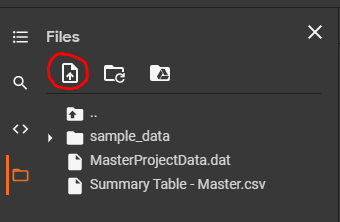
4. Hover over the file name and click on the 3 dots that appear to the right
5. Select "Copy Path"
6. You will be prompted with an input to paste the data file path below. 
7. Scroll to the bottom of the file to paste the input and let the rest of the code run on its own. 

## Solve the Model

The model can now be merged with the data file. This will solve the model. The results will be printed below. The execution will take between 7-8 minutes to fully resolve. 

The results will display the cube pairing assignments in addition to the schedule for each day of the week. The schedule for each day displays the student name and then the hours they have been assigned. 

The total number of hours assigned to each student in a given week and per day are also displayed. The total number of occupied cubes per hour of each day is also printed.

As stated above, all data solved is organized and printed within the Python output. Below you will find steps onto how the data is visualized within Excel.  

---



In [39]:
# IMPORT DATA FILE TO CODE ********* PASTE DATA IN THIS CODE
print("Please paste data file path here:")
data_file = input()
print()

data = DataPortal()
data.load(filename= data_file, model=model)

# OPTIMIZE PROBLEM BASED ON CONSTRAINTS
optimizer = SolverFactory("glpk")
instance = model.create_instance(data)
results = optimizer.solve(instance)

# SOLVE AND DISPLAY ALL VALUES THAT ARE 1
#If the model was able to solve to optimality print the results 
if (results.solver.status==SolverStatus.ok) and (results.solver.termination_condition==TerminationCondition.optimal):
  #instance.display()  

  print("************************** RESULTS OF OFFICE OPTIMIZATION BY COVID REGULATIONS AND RESTRICTIONS **************************")

#If the model was infeasible let the user know
elif (results.solver.termination_condition==TerminationCondition.infeasible or results.solver.termination_condition == TerminationCondition.other):
	print("Model is INFEASIBLE. Check Constraints")

#If the model was not solved to optimality and wasn't infeasible, print out the status and termination condition
else: 
	print("Solver Status: ", results.solver.status)
	print("Termination Condition: ", results.solver.termination_condition)


#DATA FRAME CODES
pd.set_option("display.max_rows", None, "display.max_columns", None)
Summary_Table = pd.DataFrame()
Cubicle_Table = pd.DataFrame()

for h in instance.DAY:
  for i in instance.CUBICLE:
    for j in instance.STUDENT:
      for k in instance.HOURS:
        if instance.x[i,j,k,h]==1:
          Summary_Table=Summary_Table.append({'Day':h, "Student":j, "Hour":k}, ignore_index=True)

for h in instance.DAY:
  for i in instance.CUBICLE:
    for j in instance.STUDENT:
      for k in instance.HOURS:
        if instance.x[i,j,k,h]==1:
          Cubicle_Table=Cubicle_Table.append({"Student":j, "Cubicle":i}, ignore_index=True)

Cubicle_Table.Cubicle = Cubicle_Table.Cubicle.astype(int)

CT = Cubicle_Table.drop_duplicates()

Summary_Table.Hour = Summary_Table.Hour.astype(int)

Summary_Table = Summary_Table.reset_index(drop=True)
CT = CT.reset_index(drop=True)

pivot1 = Summary_Table.pivot_table(index=["Student", "Day"], values=["Hour"], aggfunc='count')

pivot2 = Summary_Table.pivot_table(index=["Hour", "Day"], values=["Hour"], aggfunc='count')

pivot3 = Summary_Table.pivot_table(index=["Student"], values=["Hour"], aggfunc='count')

rows = len(Summary_Table.axes[0])

sunday = Summary_Table[Summary_Table.Day.isin(["Sunday"])]
sunday = sunday[["Student", 'Hour']]

monday = Summary_Table[Summary_Table.Day.isin(["Monday"])]
monday = monday[["Student", 'Hour']]

tuesday = Summary_Table[Summary_Table.Day.isin(["Tuesday"])]
tuesday = tuesday[["Student", 'Hour']]

wednesday = Summary_Table[Summary_Table.Day.isin(["Wednesday"])]
wednesday = wednesday[["Student", 'Hour']]

thursday = Summary_Table[Summary_Table.Day.isin(["Thursday"])]
thursday = thursday[["Student", 'Hour']]

friday = Summary_Table[Summary_Table.Day.isin(["Friday"])]
friday = friday[["Student", 'Hour']]

saturday = Summary_Table[Summary_Table.Day.isin(["Saturday"])]
saturday = saturday[["Student", 'Hour']]

Summary_Table = Summary_Table[["Day", "Hour", "Student"]]
Summary_Table.to_csv(r'/content/Summary Table - Master.csv', index=False)

CT = CT[["Student", "Cubicle"]]

#PRINT ALL OF PANDA DATA FRAMES
print()
print("Preference Hours Used:", rows)
print()
print("Times Students Allowed in Office (in Military Time):", list(instance.HOURS)[0], "-", list(instance.HOURS)[-1], "\n")

print()
print("***************************Summary of Total Hours For Students***************************\n")
print(pivot3)

print()
print("***************************Schedule for Sundays***************************\n")
print(sunday)

print()
print("***************************Schedule for Mondays***************************\n")
print(monday)

print()
print("***************************Schedule for Tuesdays***************************\n")
print(tuesday)

print()
print("***************************Schedule for Wednesdays***************************\n")
print(wednesday)

print()
print("***************************Schedule for Thursdays***************************\n")
print(thursday)

print()
print("***************************Schedule for Fridays***************************\n")
print(friday)

print()
print("***************************Schedule for Saturdays***************************\n")
print(saturday)

print()
print("***************************Summary of Total Hours For Students - Day Breakdown***************************\n")
print(pivot1)

print()
print("***************************Summary of Total Cubicles Occupied Per Day at Each Time***************************\n")
print(pivot2)

pd.set_option("display.max_rows", 2, "display.max_columns", None)
print()
print("***************************Cubicle Assignments***************************\n")
print(CT)


Please paste data file path here:
/content/MasterProjectData.dat

************************** RESULTS OF OFFICE OPTIMIZATION BY COVID REGULATIONS AND RESTRICTIONS **************************

Preference Hours Used: 1325

Times Students Allowed in Office (in Military Time): 8 - 20 


***************************Summary of Total Hours For Students***************************

          Hour
Student       
Adbullah    36
Allison     40
Andrea      37
Carlos      36
Fatemeh     39
Hatem       40
Hrushi      36
Jamal       36
Jean        36
Jennifer    36
Jeremy      36
Khushbu     36
Madeline    36
Marcos      39
Masoud      38
Matthew     36
Mengdi      36
Ming        36
Mohammed    36
Nicholas    36
Omar        36
Paul        36
Pranav      36
Prashant    36
Pritam      38
Quitaba     36
Saif        40
Sri         36
Teju        37
Theresa     36
Usama       37
Victoria    40
William     36
Xi          36
Yousef      36
Yu          36

***************************Schedule for Sundays*********

##Visualize Results

To visualize the results download the Dashboard excel file.


1. Download the CSV file created by running this code (this file can be located in the folder icon. This is located in the same place where the data file is uploaded. It is named "Summary Table - Master.csv")
2. Download the Dashboard Excel file [link to Dashboard file here](https://drive.google.com/file/d/1ALkoK1tSqs8QtO9mixVLQzJqTMkCpln1/view?usp=sharing) (best if downloaded and run using Excel)
3. Copy and paste the data from the CSV file into the "copy here" section of the Dashboard file. 
4. When data is first uploaded into the document, click the "REFRESH" button **twice** ensure dashboard refreshes properly. 
4. Choose which students schedule you would like to view and for which day from the dropdown menu 






## Conclusions

We are very happy with the results of our model and believe the students will also be happy with the results. We have assigned every student to at least 36 hours in their cube with an average request to assigned match rate of about 90%. We have also maximized nearly every possible hour to the total number of students that can be in the building at a time.

For future improvements to the model, the pairings of PhD students to cube assignments could be revisted. These pairings could be optimized to the students schedules to potentially increase the number of hours they can work in a cube. Another improvement that could be made to the model is to set a limit for the number of non-requested hours a student can be assigned. This would prevent any one student from receieving significantly less of their requested hours than other their peers. 


